# Дз 4 

Деревья

Сначала используем все готовые функции, затем внемсем именения

In [936]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [937]:
leaves_count = 0
max_leaves = 10
max_depth = 6

In [938]:
classification_data, classification_labels = datasets.make_classification(n_samples = 1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=1)

In [939]:
len(classification_labels)

1000

In [940]:
map(lambda x: x[0], classification_data)

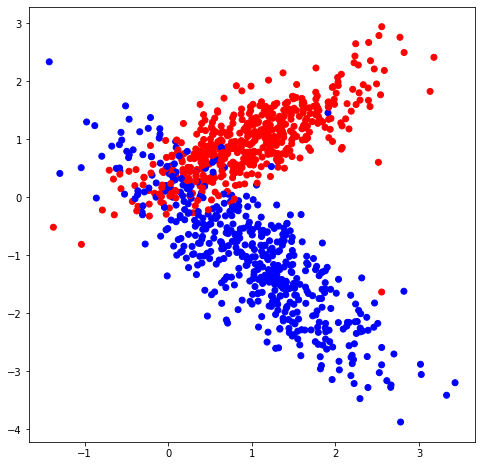

In [941]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### Чтобы отслеживать глубину дерева, протянем переменную - глубину

In [942]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, depth, parent_node):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        self.depth = depth  # глубина этого узла
        self.parent_node = parent_node  # ссылка на родительский узел

#### Теперь при каждой инициализации листа будем добавлять счетчик лситьев - глобальную переменную

In [943]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        global leaves_count
        leaves_count += 1
        
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [944]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [945]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [946]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

## 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [947]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

#### Здесь 
* введем максимальную глубину и откажемся погружаться сильнее
* введем максимальное количество листьев и откажем их плодить больше допустимого. 

In [948]:
# Построение дерева с помощью рекурсивной функции



def build_tree(data, labels, parent_node = None):
    global leaves_count
    leaves_count += 1 # Здесь мы на каждом шаге будем увеличивать это число, ведь данный узел - потенциальный лист
    # Если нет роительского узла
    if parent_node is None:
        cur_node = Node(None, None, None, None, 0, None)
    # Если есть родительский узел
    else:
        cur_node = Node(parent_node.index, parent_node.t, parent_node.true_branch, parent_node.false_branch, parent_node.depth + 1,parent_node)
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Если у текущего узла глубина достигла максимальной, возвращаем лист
    if cur_node.depth >= max_depth:
        return Leaf(data, labels)
    
    # Если потенциальное кол-во листьев достигло максимума - пора останавливаться
    if leaves_count >= max_leaves:
        return Leaf(data, labels)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, cur_node)
    false_branch = build_tree(false_data, false_labels, cur_node)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, cur_node.depth, cur_node)

In [949]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [950]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [951]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [952]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, None)

In [953]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.058316533655986325
--> True:
  Индекс 0
  Порог 0.0899815074171253
  --> True:
    Индекс 1
    Порог -0.5375137390572966
    --> True:
      Прогноз: 1
    --> False:
      Индекс 1
      Порог -0.06958844396622843
      --> True:
        Индекс 0
        Порог -0.3781043120465053
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 1
--> False:
  Прогноз: 0


In [954]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [955]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [956]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [957]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

90.71428571428571

In [958]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.33333333333333

/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_23885/3498025306.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
/var/folders/zn/1572lrw14snff0mc3dlr9grc0000gn/T/ipykernel_23885/3498025306.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=90.33')

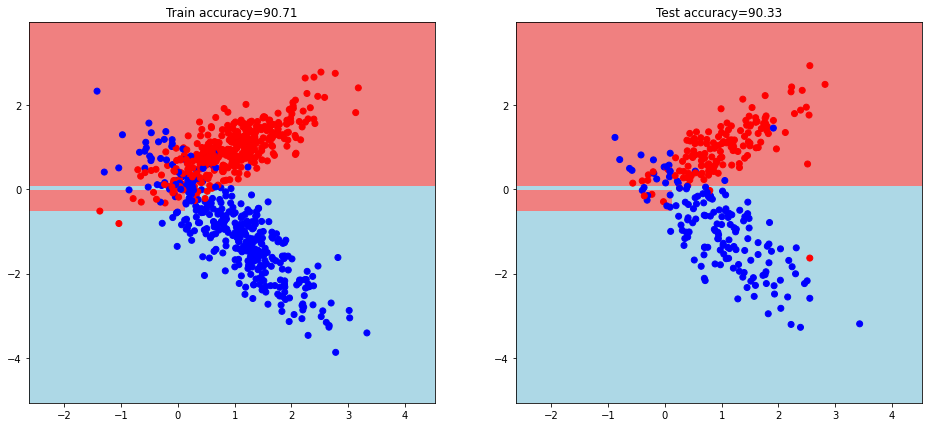

In [959]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## 2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [960]:
leaves_count = 0

In [961]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет дисперсии
    
    impurity = 1./len(labels) * np.sum( (labels - np.mean(labels))**2 )        
    return impurity

In [962]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        global leaves_count
        leaves_count += 1
        
        
    def predict(self):
        # Кол-во элемемнтов в листе
        X_n = len(self.data) 
        
        prediction = 1./X_n * np.sum(self.labels)
        
        return prediction        

In [963]:
# Построим дерево по обучающей выборке
my_tree_regression = build_tree(train_data, train_labels, None)
print_tree(my_tree_regression)

Индекс 1
Порог 0.058316533655986325
--> True:
  Индекс 0
  Порог 0.0899815074171253
  --> True:
    Индекс 1
    Порог -0.5375137390572966
    --> True:
      Прогноз: 0.8571428571428571
    --> False:
      Индекс 1
      Порог -0.06958844396622843
      --> True:
        Индекс 0
        Порог -0.3781043120465053
        --> True:
          Прогноз: 0.0
        --> False:
          Прогноз: 0.3333333333333333
      --> False:
        Прогноз: 0.5714285714285714
  --> False:
    Прогноз: 0.9790209790209791
--> False:
  Прогноз: 0.13624678663239073


In [964]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = classify_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [949]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# Посмотрим, что пол

In [976]:
test_data[0:10], predict(test_data[0:10], my_tree_regression)

(array([[ 1.62296491,  1.61807297],
        [ 3.43069536, -3.19648007],
        [ 0.51518054,  1.21249555],
        [ 0.80331414, -0.15228044],
        [ 1.84303255, -0.78710066],
        [ 0.64253181,  0.56360243],
        [ 0.4171377 ,  0.38130166],
        [ 1.12229947, -1.63800228],
        [ 0.47152927,  0.79430654],
        [ 0.55510723,  1.36717017]]),
 [0.13624678663239073,
  0.9790209790209791,
  0.13624678663239073,
  0.9790209790209791,
  0.9790209790209791,
  0.13624678663239073,
  0.13624678663239073,
  0.9790209790209791,
  0.13624678663239073,
  0.13624678663239073])

In [ ]:
test_data[0]